# Notebook 04: Analysis of Color in U.S. Movie Posters (1980-2019)

Our final notebook returns to the movie posters to investiage the use of color
across time and genre.

Once again, start by running the following lines to load some standard Python libraries
and set up plotting in the Jupyter notebook:

In [1]:
%pylab inline

import numpy as np
import scipy as sp
import pandas as pd
import json

import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
from os.path import join, basename

Populating the interactive namespace from numpy and matplotlib


In [2]:
def conf_int(vals, ndigits=1):
    se = 1.96 * np.sqrt(np.var(vals) / len(vals))
    mu = np.mean(vals)
    return [round(mu - se, ndigits=ndigits), round(mu + se, ndigits=ndigits)]

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams["figure.figsize"] = (8,8)

## 1. Create a Code System

Let's again look at an exaple movie poster:

In [4]:
img_paths = [join("images", "posters", x) for x in os.listdir(join("images", "posters"))]

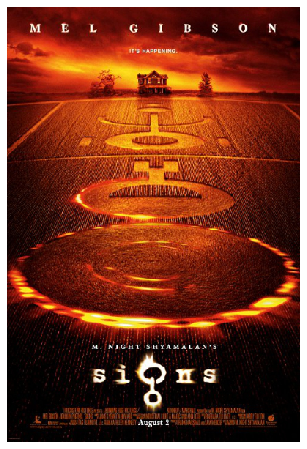

In [5]:
img = imread(img_paths[(200)])
plt.imshow(img)
_ = plt.axis("off")

How is color used to sell the movie in this poster? What kinds of features would you
like to extract from the image?

## 2. Annotate the Corpus


### 2a. Extract information from the visual material

For the color analysis, we will use two annotators, `ColorHistogramAnnotator` and
`DominantColorAnnotator`. As in Notebook03, we will test this out on a small set
of the posters before loading the rest of the data from a pre-computed cache
in the interest of time.

In [6]:
from dvt.core import DataExtraction, ImageInput
from dvt.annotate.color import ColorHistogramAnnotator, DominantColorAnnotator

In [7]:
input_obj = ImageInput(input_paths=img_paths[:10])
dextra = DataExtraction(input_obj)
dextra.run_annotators([
    ColorHistogramAnnotator(num_buckets=(16, 4, 8)),
    DominantColorAnnotator()
])

The output contains, in addiontion to the metadata, information about the
five dominant colors in each poster as well as information about the specific
hues, values, and saturations:

In [8]:
dt = dextra.get_json()

dt.keys()

dict_keys(['meta', 'colorhist', 'domcolor'])

Here is the dominant color information:

In [9]:
dt['domcolor']

[{'dominant_colors': ['#94634c', '#020305', '#1b120f', '#503227', '#beb0a4'],
  'frame': 0},
 {'dominant_colors': ['#574954', '#8d8089', '#2a252c', '#cac5ca', '#06090d'],
  'frame': 1},
 {'dominant_colors': ['#6c7aa0', '#b05a2e', '#c7beab', '#342f42', '#fbfdfd'],
  'frame': 2},
 {'dominant_colors': ['#130f12', '#ced2d9', '#7e7b85', '#463139', '#e8ebed'],
  'frame': 3},
 {'dominant_colors': ['#988643', '#5b5833', '#0a0d0d', '#2d311b', '#d4c37e'],
  'frame': 4},
 {'dominant_colors': ['#d21611', '#0a0a0a', '#514744', '#99a19f', '#dde2df'],
  'frame': 5},
 {'dominant_colors': ['#3d3b44', '#aba6a1', '#e7e2df', '#070508', '#6d676f'],
  'frame': 6},
 {'dominant_colors': ['#695241', '#987055', '#493932', '#f7d180', '#d3a16b'],
  'frame': 7},
 {'dominant_colors': ['#961623', '#854f41', '#3c1414', '#c7193f', '#b98373'],
  'frame': 8},
 {'dominant_colors': ['#7ea2c3', '#50789e', '#2c5275', '#202c3e', '#bcd2e7'],
  'frame': 9}]

The histogram data is quite large (512 numbers for each poster):

In [10]:
len(dt['colorhist'][0]['hsv'])

512

Here are the first few entries:

In [11]:
dt['colorhist'][0]['hsv'][:10]

[58931.0, 175.0, 150.0, 175.0, 332.0, 1204.0, 1554.0, 56.0, 13601.0, 3991.0]

### 2b. Aggregate information across the corpus

Now, let's load the fully annotated version of the corpus:

In [12]:
with open(join('cache', 'movie_color.json'), 'r') as json_file:
    dt = json.load(json_file)

The histograms as a bit complex and require further processing before
they are very useful. Here, we count the number of pixels that are 
dark, heavily saturated, red, and white. We will also restructure the
dominant color information to better integrate it into a rectangular
dataset.

In [13]:
paths = [basename(x['paths']) for x in dt['meta']]

dark_count = np.zeros((len(dt['meta'])))
saturated_count = np.zeros((len(dt['meta'])))
red_count = np.zeros((len(dt['meta'])))
white_count= np.zeros((len(dt['meta'])))
for i, hist in enumerate(dt['colorhist']):
    img_hist = np.array(hist['hsv']).reshape((16, 4, 8))
    dark_count[i] = np.sum(img_hist[:,:,:3])
    saturated_count[i] = np.sum(img_hist[:,3,4:])
    red_count[i] = np.sum(img_hist[:2,2:,4:])
    white_count[i] = np.sum(img_hist[:,0,4:])

    
dom_cols = []
for i, dc in enumerate(dt['domcolor']):
    dom_cols.append(dc['dominant_colors'])

And, finally, convert these values into a structured table:

In [14]:
color_info = pd.DataFrame({
    'img': paths,
    'dark_perc': dark_count / (594 * 4),
    'saturated_perc': saturated_count / (594 * 4), 
    'red_perc': red_count / (594 * 4),
    'white_perc': white_count/ (594 * 4),
    'dom_cols': dom_cols
})
color_info

img  dark_perc  saturated_perc  \
0                    1987_evil_dead_ii.jpg  73.246633        1.167929   
1         1999_the_blair_witch_project.jpg  85.374579        0.000000   
2                    2002_lilo__stitch.jpg   7.607323        5.224327   
3                  1993_grumpy_old_men.jpg  29.696970        0.001684   
4            2004_the_bourne_supremacy.jpg  58.355640        0.740741   
...                                    ...        ...             ...   
3675                        2018_mile_.jpg  41.944024        0.940236   
3676               1986_trick_or_treat.jpg  72.978114       10.085859   
3677  2012_snow_white_and_the_huntsman.jpg  49.525673        0.000000   
3678                         1982_tron.jpg  78.853956        1.196128   
3679                 2008_leatherheads.jpg  43.482323        0.260943   

       red_perc  white_perc                                       dom_cols  
0      2.040825   12.942340  [#020305, #bfb1a5, #513328, #1a1110, #95644d]  
1      0.000000   10.657828  [#2a252c, #8d8089, #06090d, #cac5ca, #574954]  
2      6.226852   58.980219  [#af592d, #fbfdfd, #6b769d, #322e40, #c4bcaa]  
3      0.059343   59.772727  [#cdd0d8, #e7ebee, #4a353c, #151114, #817e88]  
4     11.140152    4.944444  [#2b2f1a, #0a0d0d, #958443, #d4c17a, #595633]  
...         ...         ...                                            ...  
3675   1.156566   53.625842  [#b1b1b1, #dae0de, #634d47, #242726, #7d7d7d]  
3676  16.750421    2.795875  [#f0bb6c, #c9693d, #7e3328, #0f0907, #391a16]  
3677   0.000000   38.880892  [#1c2126, #353f46, #5c6a73, #d1d9dd, #94a4ac]  
3678   0.856061    4.266414  [#402b3e, #cbd1e6, #3f4f94, #977b93, #060a10]  
3679   2.320286   32.016835  [#10070e, #826b62, #ececec, #4d3336, #b39f99]  

[3680 rows x 6 columns]

## 3. Combine with Metadata


As shown in Notebook02, we have extensive metadata for the movie posters. Let's join
this with our extracted color information:

In [15]:
df = pd.read_csv(join("meta", "poster_metadata.csv"))
df = df.join(color_info.set_index('img'), on='img')
df

year                                           title  \
0     1980  Star Wars: Episode V - The Empire Strikes Back   
1     1980                                     Superman II   
2     1980                                    Nine to Five   
3     1980                                      Stir Crazy   
4     1980                                       Airplane!   
...    ...                                             ...   
3675  2019                         The Art of Self-Defense   
3676  2019                                            Luce   
3677  2019       The Other Side of Heaven 2: Fire of Faith   
3678  2019                                   The Aftermath   
3679  2019                                         The Kid   

                                                    img  rating_count  \
0     1980_star_wars_episode_v__the_empire_strikes_b...       1101823   
1                                  1980_superman_ii.jpg         94018   
2                                 1980_nine_to_five.jpg         25807   
3                                   1980_stir_crazy.jpg         23761   
4                                     1980_airplane.jpg        198432   
...                                                 ...           ...   
3675                    2019_the_art_of_selfdefense.jpg         18474   
3676                                      2019_luce.jpg          5800   
3677   2019_the_other_side_of_heaven__fire_of_faith.jpg           259   
3678                             2019_the_aftermath.jpg         13203   
3679                                   2019_the_kid.jpg          5210   

            gross                        genre rating  runtime  stars  \
0     290480000.0   Action, Adventure, Fantasy     PG    124.0    8.7   
1     108190000.0    Action, Adventure, Sci-Fi     PG    127.0    6.8   
2     103290000.0                       Comedy     PG    109.0    6.8   
3     101300000.0                Comedy, Crime      R    111.0    6.8   
4      83400000.0                       Comedy     PG     88.0    7.7   
...           ...                          ...    ...      ...    ...   
3675    2410000.0         Comedy, Crime, Drama      R    104.0    6.7   
3676    1780000.0                        Drama      R    109.0    6.8   
3677    1720000.0  Adventure, Biography, Drama  PG-13    117.0    5.1   
3678    1620000.0          Drama, Romance, War      R    108.0    6.3   
3679    1510000.0    Biography, Drama, Western      R    100.0    5.9   

      metacritic                                        description  \
0            NaN  After the Rebels are brutally overpowered by t...   
1            NaN  Superman agrees to sacrifice his powers to sta...   
2           58.0  Three female employees of a sexist, egotistica...   
3           56.0  Set up and wrongfully accused, two best friend...   
4            NaN  A man afraid to fly must ensure that a plane l...   
...          ...                                                ...   
3675         NaN  After being attacked on the street, a young ma...   
3676         NaN  A married couple is forced to reckon with thei...   
3677         NaN  Missionary John H. Groberg returns to Tonga in...   
3678        43.0  Post World War II, a British colonel and his w...   
3679        51.0  The story of a young boy who witnesses Billy t...   

      dark_perc  saturated_perc   red_perc  white_perc  \
0     59.121212        0.039562   0.702020   14.895623   
1     63.954545        0.943603   2.651094   13.286195   
2      9.767677        0.110269   3.830387   40.373316   
3      6.730219        8.105640   7.940657   69.067761   
4      7.095960        4.544613   3.659512   44.077020   
...         ...             ...        ...         ...   
3675  22.493266       47.032407   3.281145   14.335017   
3676   9.150673        0.001263   0.013047   79.784512   
3677  12.079966        5.726431  22.956229   31.899832   
3678  74.998316        0.000000   2.585017    1.147306   
3679  56.520202 

## 4. Exploratory Analysis

### Visualizing color data

To start, we will look at posters that have the largest value for each of the extracted
measurments that we have stored. Along the way, we will try to formulat some hypotheses
about the patterns that may exist across the whole corpus.

Here are the darkest images:

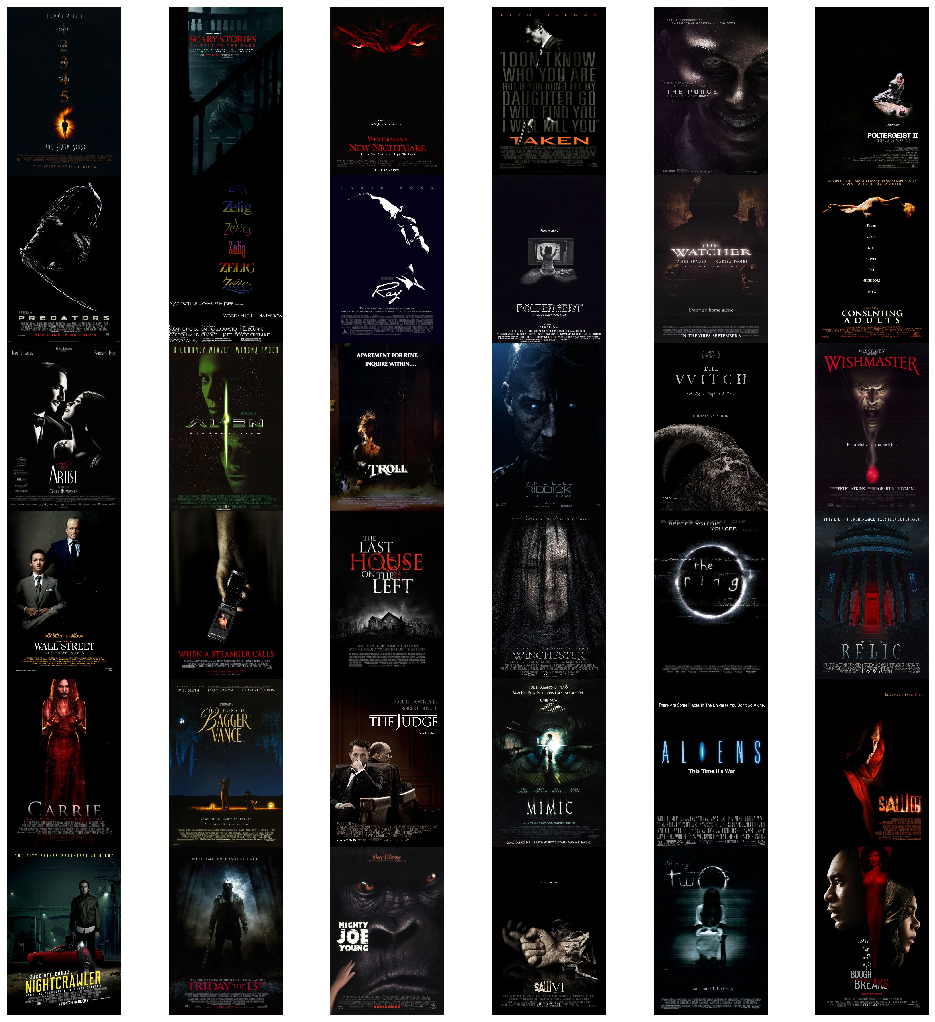

In [16]:
plt.figure(figsize=(14, 14))

nx = 6
ny = 6

df = df.sort_values('dark_perc', ascending=False)

pnum = 1
for j, row in df[:36].iterrows():
    img = imread(join('images', 'posters', row['img']))
    plt.subplot(ny, nx, pnum)
    plt.imshow(img)
    plt.axis("off")
    pnum += 1
    
plt.tight_layout(pad=0)

Compared with the most highly saturated:

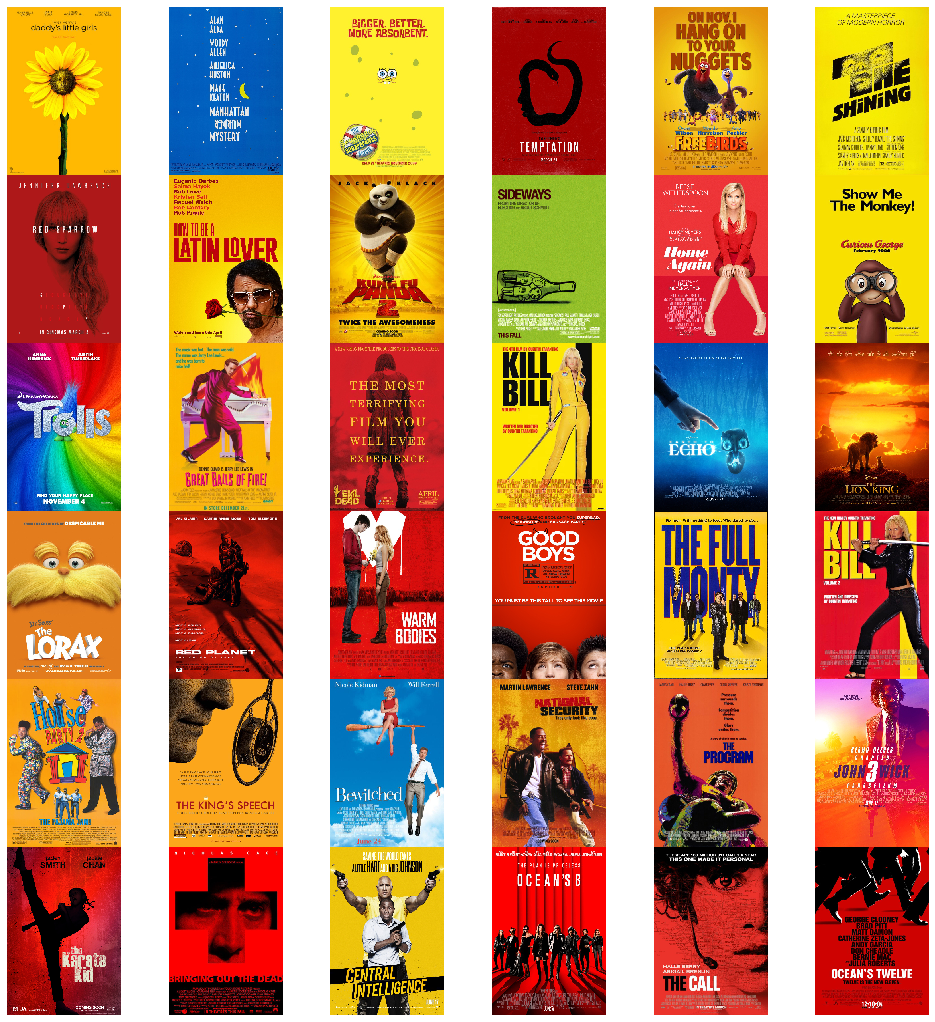

In [17]:
plt.figure(figsize=(14, 14))

nx = 6
ny = 6

df = df.sort_values('saturated_perc', ascending=False)

pnum = 1
for j, row in df[:36].iterrows():
    img = imread(join('images', 'posters', row['img']))
    plt.subplot(ny, nx, pnum)
    plt.imshow(img)
    plt.axis("off")
    pnum += 1
    
plt.tight_layout(pad=0)

And the posters with the highest percentage of red:

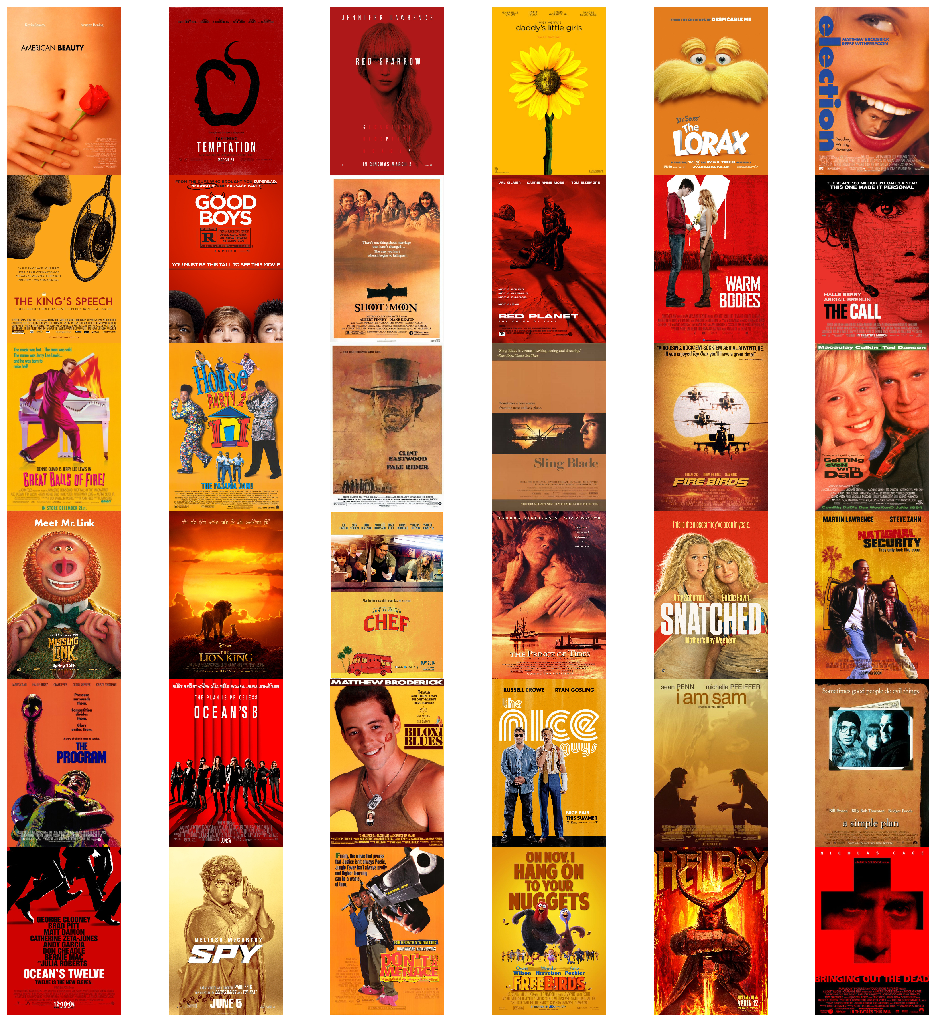

In [18]:
plt.figure(figsize=(14, 14))

nx = 6
ny = 6

df = df.sort_values('red_perc', ascending=False)

pnum = 1
for j, row in df[:36].iterrows():
    img = imread(join('images', 'posters', row['img']))
    plt.subplot(ny, nx, pnum)
    plt.imshow(img)
    plt.axis("off")
    pnum += 1
    
plt.tight_layout(pad=0)

And finally, the largest amount of white:

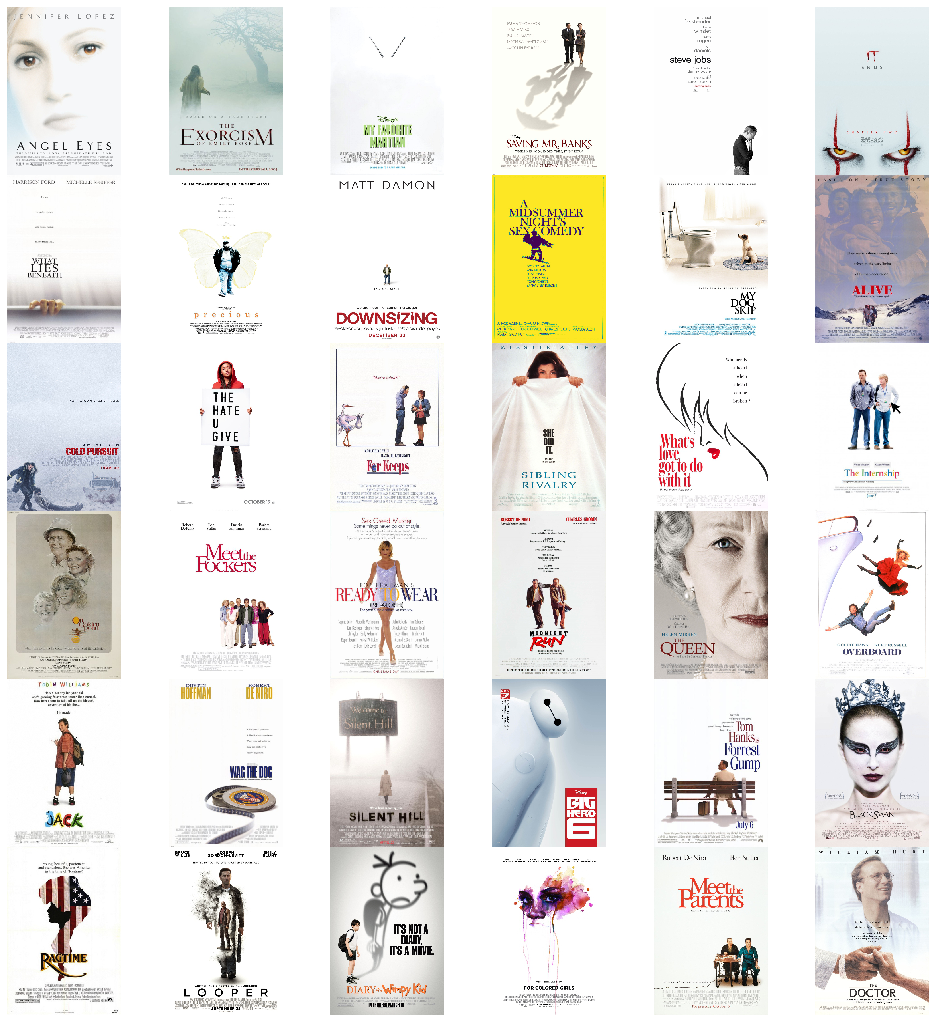

In [19]:
plt.figure(figsize=(14, 14))

nx = 6
ny = 6

df = df.sort_values('white_perc', ascending=False)

pnum = 1
for j, row in df[:36].iterrows():
    img = imread(join('images', 'posters', row['img']))
    plt.subplot(ny, nx, pnum)
    plt.imshow(img)
    plt.axis("off")
    pnum += 1
    
plt.tight_layout(pad=0)

### Visualizing dominant colors

Our algorithm also extracts dominant colors from each poster. Here is the code
to look at these for a set of posters (we choose the most highly saturated, but
feel free to modify the sorting algorithm to look at a different set).

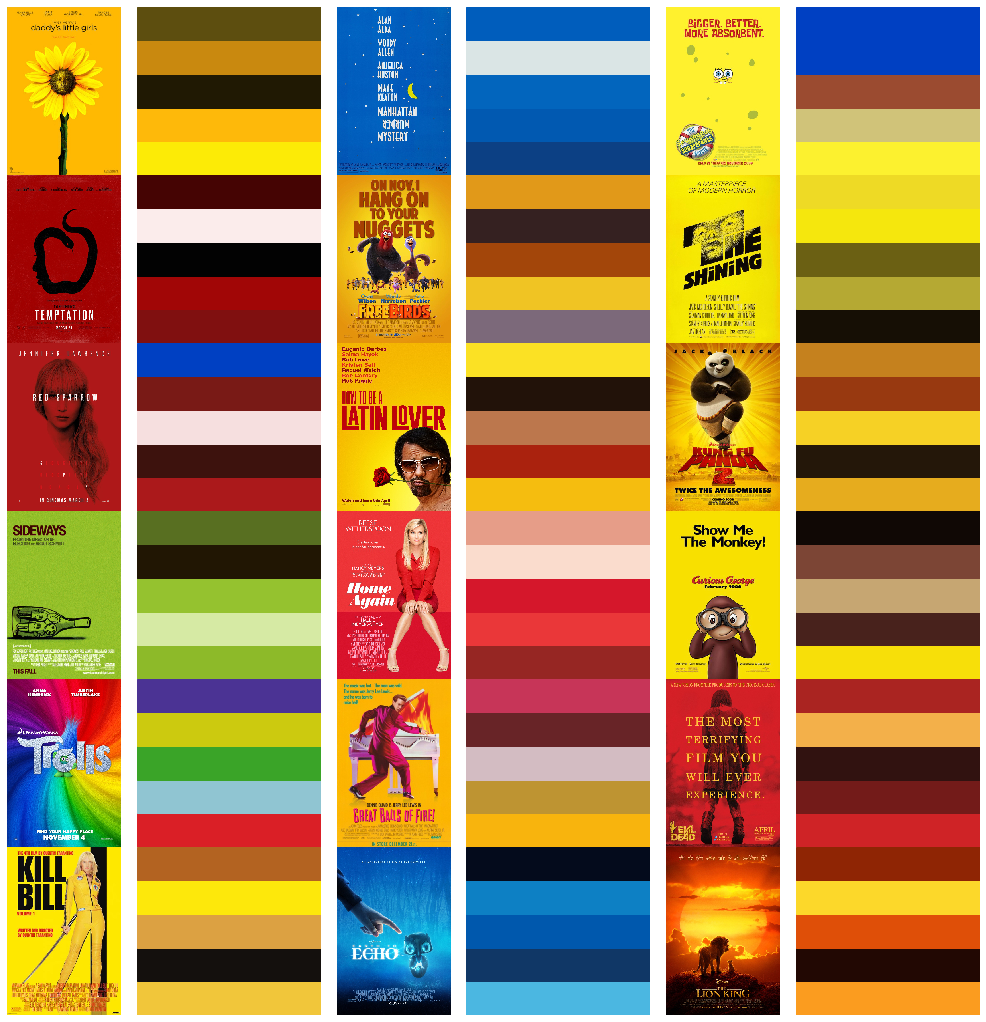

In [20]:
plt.figure(figsize=(14, 14))

nx = 6
ny = 6

df = df.sort_values('saturated_perc', ascending=False)

pnum = 1
for j, row in df[:18].iterrows():
    img = imread(join('images', 'posters', row['img']))
    plt.subplot(ny, nx, pnum)
    plt.imshow(img)
    plt.axis("off")
    pnum += 1
    
    ax = plt.subplot(ny, nx, pnum)
    for i, cn in enumerate(row['dom_cols']):
        circ = plt.Rectangle((0, i  / 5), 1, 0.2, color=cn)
        ax.add_artist(circ)
        plt.axis("off")
        
    pnum += 1
    
plt.tight_layout(pad=0)

### Color; genre; year

Now, let's see how color differs (on average) across different
genres. For example, how dark are the posters for each genre:

<ErrorbarContainer object of 3 artists>

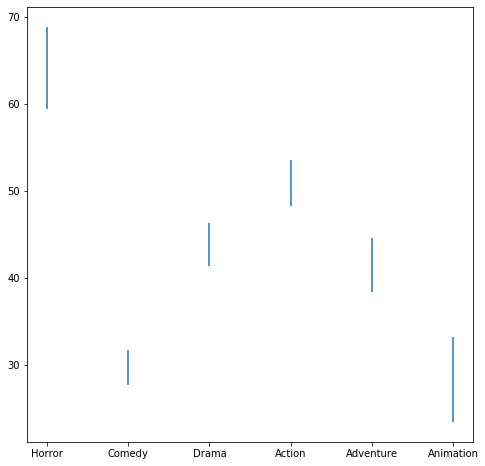

In [21]:
x = ['Horror', 'Comedy', 'Drama', 'Action', 'Adventure', 'Animation']
y = []
esize = []

for genre in x:
    ci = conf_int(df[df['genre'].str.contains(genre)].dark_perc.values)
    y.append((ci[0] + ci[1]) / 2)
    esize.append(ci[1] - ci[0])
    
plt.errorbar(x, y, yerr=esize, fmt='none')

Or, which posters have the most saturated colors:

<ErrorbarContainer object of 3 artists>

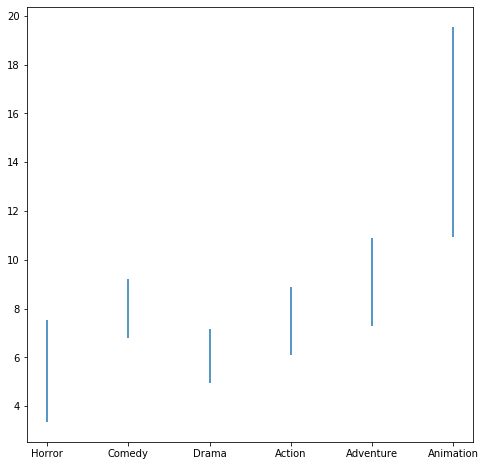

In [22]:
x = ['Horror', 'Comedy', 'Drama', 'Action', 'Adventure', 'Animation']
y = []
esize = []

for genre in x:
    ci = conf_int(df[df['genre'].str.contains(genre)].saturated_perc.values)
    y.append((ci[0] + ci[1]) / 2)
    esize.append(ci[1] - ci[0])
    
plt.errorbar(x, y, yerr=esize, fmt='none')

Plotting the amount of white seems to be (perhaps unsurprisingly)
the inverse of the amount of dark pixels that are present in each
genre.

<ErrorbarContainer object of 3 artists>

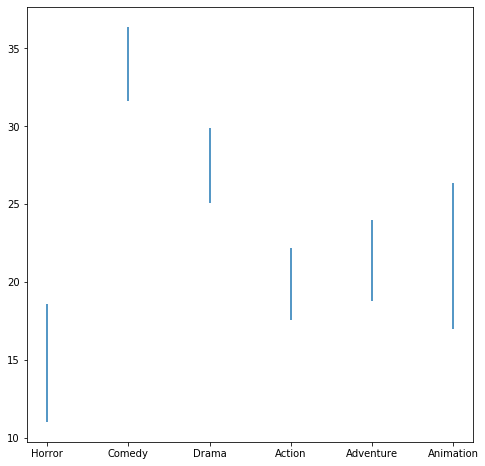

In [23]:
x = ['Horror', 'Comedy', 'Drama', 'Action', 'Adventure', 'Animation']
y = []
esize = []

for genre in x:
    ci = conf_int(df[df['genre'].str.contains(genre)].white_perc.values)
    y.append((ci[0] + ci[1]) / 2)
    esize.append(ci[1] - ci[0])
    
plt.errorbar(x, y, yerr=esize, fmt='none')

The amount of white also seems to change across time:

<ErrorbarContainer object of 3 artists>

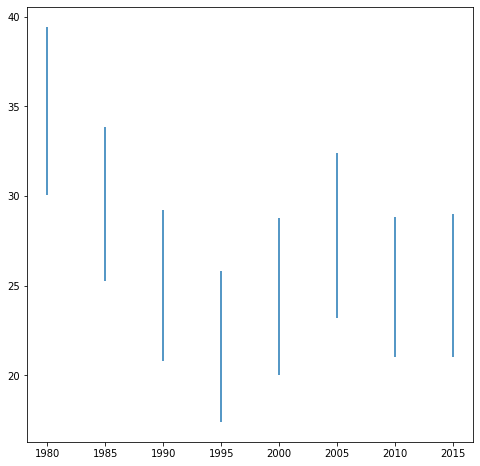

In [24]:
x = []
y = []
esize = []

for start in range(1980, 2020, 5):
    end = start + 4
    ci = conf_int(df[(df['year'] >= start) & (df['year'] <= end)].white_perc.values)
    x.append(start)
    y.append((ci[0] + ci[1]) / 2)
    esize.append(ci[1] - ci[0])
    
plt.errorbar(x, y, yerr=esize, fmt='none')

What do you take away from these results? Again, do they confirm or challenge
your initial understanding of movie posters? What other kinds of analysis would
you like to run on the movie posters?

## 5. Communication

The DVT visualization that we ran in the browser in the first notebook does not include
a visualization of the color information. Do you have any thoughts on how this could be
incorporated?